In [1]:
from joblib import dump, load
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn import metrics

In [2]:
import pandas as pd

In [3]:
df = load('./data/prepared_dataframe.joblib')

In [4]:
# Filter out some types
df = df[df['target'] != 4].copy()
df = df[df['target'] != 10].copy()
# df = df[df['target'] != 2].copy()

In [5]:
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
tfidf_vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    max_features=5000,
    max_df=0.9,
    min_df=0.001,
    ngram_range=(1,2)
)
data_X = tfidf_vectorizer.fit_transform(df['data_lema'])
data_Y = df['target']

In [7]:
len(tfidf_vectorizer.get_feature_names_out())

5000

In [8]:
clf = SGDClassifier(
    loss='log', penalty='l2',
    alpha=1e-5, random_state=42,
    max_iter=5, tol=None)

In [10]:
# Evaluating the model score
scores_list = cross_val_score(clf, data_X, data_Y, cv = 5)
np.mean(scores_list)

0.8362778448370459

In [11]:
clf.fit(data_X, data_Y)
predicted = clf.predict(data_X)
predicted_scores = clf.decision_function(data_X)
# np.mean(np.logical_and(predicted == data_Y, np.amax(predicted_scores, axis=1) > 0 ))
# clf.predict_proba(data_X)

np.mean(predicted == data_Y)

0.8954680127290684

In [51]:
testing_score = 0.5

tmp_score = np.mean(
    np.logical_or(
        np.logical_and(
            np.array(list(map(lambda value: np.max(value), clf.predict_proba(data_X)))) > testing_score,
            predicted == data_Y
        ),
        np.array(list(map(lambda value: np.max(value), clf.predict_proba(data_X)))) <= testing_score
    )
)

tmp_dont_know_count = np.sum(np.array(list(map(lambda value: np.max(value), clf.predict_proba(data_X)))) <= testing_score) 

print("Tested score limit: " + str(testing_score))
print("Total: " + str(len(data_Y)))
print("Score sur certitude: " + str(tmp_score))
print("Count dont know: " + str(tmp_dont_know_count))
print("Dont know ratio: " + str(tmp_dont_know_count / len(data_Y)))

Tested score limit: 0.5
Total: 45565
Score sur certitude: 0.9401953253593767
Count dont know: 4530
Dont know ratio: 0.09941841325578843


<AxesSubplot:xlabel='target_class', ylabel='predicted_class'>

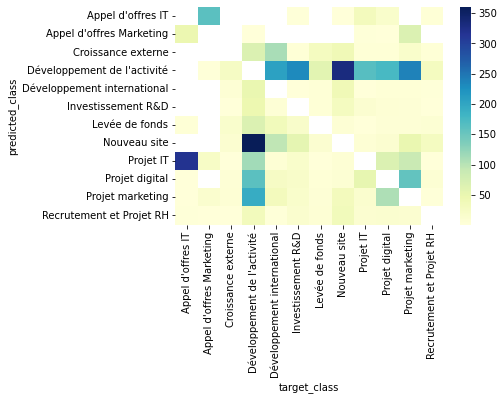

In [82]:
import seaborn as sns

result_details = pd.DataFrame(data = {
    'success': predicted == data_Y,
    'predicted': predicted,
    'target': data_Y
})
result_details = result_details[result_details['success'] == False][['target','predicted']].copy()
# result_details = result_details[['target','predicted']].copy()

txt_match = dict({
    1: "Croissance externe",
    2: "Développement de l'activité",
    3: "Nouveau site",
    4: "Diversification",
    5: "Projet marketing",
    6: "Développement international",
    7: "Projet digital",
    8: "Projet IT",
    9: "Investissement R&D",
    10: "Entreprises en difficulté",
    11: "Recrutement et Projet RH",
    16: "Levée de fonds",
    17: "Appel d'offres IT",
    18: "Appel d'offres Marketing",
})

result_details['target_class'] = result_details['target'].apply(lambda value: txt_match[value])
result_details['predicted_class'] = result_details['predicted'].apply(lambda value: txt_match[value])

result_details = result_details[['target_class', 'predicted_class']].copy()

grouped_data = result_details.groupby(['target_class', 'predicted_class']).size().reset_index(name='counts')
sns.heatmap(grouped_data.pivot("predicted_class", "target_class", "counts"), cmap="YlGnBu")

In [342]:
# clf.decision_function(data_X)
# clf.classes_
# print(metrics.classification_report(data_Y, predicted))

In [44]:
dump(clf, './data/trained_model_sgdclassifier.joblib')
dump(tfidf_vectorizer, './data/trained_model_tfidf_vectorizer.joblib')

['./data/trained_model_tfidf_vectorizer.joblib']